In [154]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [155]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [177]:
## import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
from qutip import *
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)+(
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    for i in range(U.shape[1]):
        if U[i, i] < 0:
            U[:, i] *= -1
    U_dag = np.conjugate(U.transpose())
    
    Hs = Hs
    
    return Hs-energy[0]*np.identity(sdim),-1j*(s-sd),phi_zpf,c2
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

def sort_energy(energies,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    return sorted_energies
from scipy.sparse.linalg import expm
from scipy.linalg import logm
def floquet_spec3(omega,A,phi_ex,omega_c,g_int):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    flux = 0.48
    N = 3
    dims = 10
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    g_int1 = 0.15*2*np.pi
    dimc1 = 8
    trunc1 = dims * dimc1
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,phi_ex,N,dims)
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    a=np.abs(np.sort(np.diag(Hs)))
    omegas = snail_back.omegas
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc1)
    cd = creation(dimc1)
    Hs,charge_op = H0,v
    energies,U=np.linalg.eig(H0)
    energies,U = sort(energies,U,Hs)
    Ud = U.transpose().conjugate()
    omega_s = energies[1]
    charge_op = charge_op/2/phi_zpf
    
    Hc1, Vc1 = cavity1.hamiltonian()
    Ic1 = np.identity(dimc1)
    Is = np.identity(dims)
    Hs = np.kron(Hs,Ic1)
    Hc1 = np.kron(Is,Hc1)
    H_int1 = cavity1.g_int * np.kron(charge_op,Vc1) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)   
    Hs = Hs + Hc1 + H_int1 
    
    energies,U=np.linalg.eig(Hs)
    energies,U = sort(energies,U,Hs)
    energy1 = energies - energies[0]*np.ones(len(energies))
    energy2 = energies - energies[0]*np.ones(len(energies))

    detuning = omegas
    indexs1 = np.argmin(np.abs(energy1 - detuning * np.ones(len(energy1))))
    indexs2 = np.argmin(np.abs(energy1 - (2*detuning + snail_back.anh ) * np.ones(len(energy1))))
    indexc1 = np.argmin(np.abs(energy2 - omega_c1 * np.ones(len(energy1))))
    energys1 = energy1[indexs1]
    energyc1 = energy2[indexc1] 
    
    indexc2 = np.argmin(np.abs(energy2 - 2 * omega_c1 * np.ones(len(energy1))))
    indexsc = np.argmin(np.abs(energy1 - (detuning + omega_c1) * np.ones(len(energy1))))
    indexsc2 = np.argmin(np.abs(energy1 - (detuning + 2*omega_c1) * np.ones(len(energy1))))
    energysc = energy1[indexsc]
    energyc2 = energy2[indexc2]
    energysc2 = energy1[indexsc2]
    starkshift = energysc  - energyc1 - energys1
    selfkerr = energyc2 - 2*energyc1
#     print(selfkerr/2/np.pi)
    starkshift2 = energysc2  - 2*energyc1 - energys1 - 2*starkshift - 2*selfkerr
    
    undriven_result = np.array([energyc1/2/np.pi, starkshift/2/np.pi, selfkerr/2/np.pi])
    
    anhs = energy1[indexs2] - 2*energys1
    delta = energys1 - omega
    Hs = delta*sd@s +anhs/2*sd@sd@s@s + A/2*(s+sd)/2/phi_zpf
    energies,U=np.linalg.eig(Hs)
    energies,U = sort(energies,U,Hs)
    deltap = energies[1]-energies[0]
    Ud = U.transpose().conjugate()
    Hc = energyc1*cd@c + selfkerr/2*cd@cd@c@c
    sds = Ud@sd@s@U
    sds = np.diag(np.diag(Ud@sd@s@U,k=0),k=0)
    sds = sds+ np.diag(np.diag(Ud@sd@s@U,k=1),k=1)
    sds = sds+ np.diag(np.diag(Ud@sd@s@U,k=-1),k=-1)
    H_int = starkshift * np.kron(sds,cd@c)
    H = np.kron(np.diag(energies),Ic1) + np.kron(Is,Hc)+H_int
    energy,U = np.linalg.eig(H)
    energy,U = sort(energy,U,Hs)
    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
    energy = energy - energy[max_overlap_index]*np.ones(len(energy))
    overlaps = np.abs(U[dimc1, :])**2

    #xsa Find the index of the maximum overlap
    indexs1 = np.argmax(overlaps)
#     indexs1 = np.argmin(np.abs(np.abs(energy) - delta * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - energyc1 * np.ones(len(energy))))
    energys1 = energy[indexs1] 
    energyc1 = energy[indexc1] 
    indexc2 = np.argmin(np.abs(energy - energyc2 * np.ones(len(energy))))
    overlaps = np.abs(U[dimc1+1, :])**2

    # Find the index of the maximum overlap
    indexsc = np.argmax(overlaps)
#     indexsc = np.argmin(np.abs(energy - (energysc-omega) * np.ones(len(energy))))
    starkshift = energy[indexsc]  - energyc1 - energys1
    selfkerr = energy[indexc2]  - 2*energyc1
    
    driven_result = np.array([energyc1/2/np.pi, starkshift/2/np.pi, selfkerr/2/np.pi])
    
    return undriven_result, driven_result

In [178]:
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return np.abs(1/(factor*10**-6*der))

In [179]:
import qutip as qt 
def find_best_b_and_k(a, B, omega):
    min_diff = float('inf')  # Initialize with a very large number
    best_b = None
    best_k = None

    # Iterate over each element in B
    for b in B:
        # Iterate over each k in the range [-1000, 1000]
        for k in range(-1000, 1001):  # 1001 is used to include 1000 in the range
            diff = abs(a - (b + k * omega))
            # Update min_diff and best_b if a smaller difference is found
            if diff < min_diff:
                min_diff = diff
                best_b = b
                best_k = k

    return best_b, best_k, min_diff
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def floquet_spec(Hs,Hc, omega, A,omegas):
#     Hs[0][0] = Hs[0][0]+Hs[1][1]
#     Hs[1][1] = Hs[1][1]+Hs[1][1]
    energy = np.diag(Hs)
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc2 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexsc = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexs2 = np.argmin(np.abs(energy - (2*omegas) * np.ones(len(energy))))
    Hs = Qobj(Hs)
    
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = (2*np.pi)/omega
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)],] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(trunc1, 0),qt.basis(trunc1, indexs1),qt.basis(trunc1,indexc1),qt.basis(trunc1,indexc2),qt.basis(trunc1,indexsc)
                   ,qt.basis(trunc1,indexsc),qt.basis(trunc1,indexs2)]
    
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [-1] * 7
    max_overlaps = [0] * 7
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
#     print(max_overlaps)
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    energys1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    
    energyc1 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    
    energysc = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc, omega/2/np.pi)
    starkshift = energysc - energyg + k*omega/2/np.pi - energyc1 - energys1
    
    energyc2 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi
    
    selfkerr = energyc2-energyg - 2*energyc1
    
    energys2 = f_energies[max_overlap_indices[5]]/2/np.pi
    
    k = find_optimal_k(2*omegas/2/np.pi, energys2, omega/2/np.pi)
    energys2 = energys2 + k*omega/2/np.pi - energyg
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    return energyc1, starkshift, selfkerr,energys2 ,energys1

In [233]:
EJ = 100*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 100
flux = 0.48
N = 3
dims = 10

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 8*2*np.pi
g_int1 = 0.15*2*np.pi
dimc1 = 8
trunc1 = dims * dimc1
cavity1 = Cavity(omega_c1,g_int1,dimc1)

# omega_c2 = 3*2*np.pi
# g_int2 = 0.15*2*np.pi
# dimc2 = 100
# trunc2 = dims*dimc2
# cavity2 = Cavity(omega_c2,g_int2,dimc2)

In [316]:
import numpy as np
from joblib import Parallel, delayed
omega = 5.98 * 2 * np.pi
A = 0.001* 2 * np.pi
def compute_properties(flux):
    # Assuming SNAIL, SNAILC, and all required parameters are properly defined/imported
    snail_back = SNAIL(EJ, EC, beta, ng, ncut, flux, N, dims)
    anh = snail_back.anh
    H, op = snail_back.spectrum_charge()
    freq2 = H[2, 2] / 2 / np.pi
    snailc = SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs, charge_op = snailc.dressed_H, snailc.dressed_charge
    energy = np.diag(Hs)
    index = np.argmin(np.abs(energy - snail_back.omegas * np.ones(len(energy))))
    freq = energy[index]
    result = floquet_spec(Hs, charge_op, omega, A, freq)
    return result
flux_values = np.linspace(0.402, 0.404, 100)
# flux_values = np.linspace(0.414, 0.416, 100)
# Execute the function in parallel
floquet_results = Parallel(n_jobs=-1)(delayed(compute_properties)(flux) for flux in flux_values)
floquet_results = np.array(floquet_results )
floquet_results1 = Parallel(n_jobs=-1)(delayed(compute_properties)(flux+1e-5) for flux in flux_values)
floquet_results1 = np.array(floquet_results1)
der = (floquet_results1[:,0] - floquet_results[:,0])/1e-5

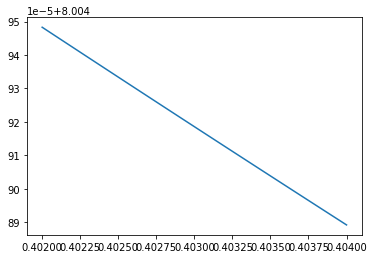

In [317]:
plt.plot(flux_values,floquet_results[:,0])

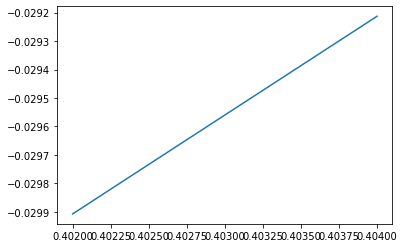

In [318]:
plt.plot(flux_values,der)

(-3e-05, 1e-05)

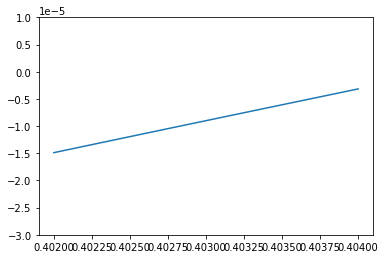

In [319]:
plt.plot(flux_values,floquet_results[:,1])
plt.ylim(-3e-5,1e-5)

(-1e-07, 1e-07)

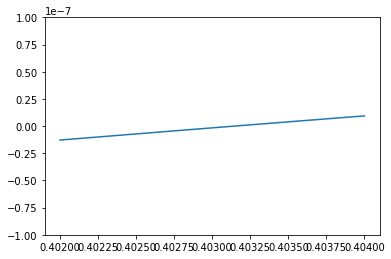

In [320]:
plt.plot(flux_values,floquet_results[:,2])
plt.ylim(-1e-7,1e-7)

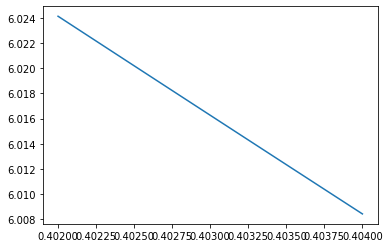

In [321]:
plt.plot(flux_values,floquet_results[:,-1])

In [271]:
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Constants
A = 0.001 * 2 * np.pi

# Updated function to accept omega
def compute_properties(flux, omega):
    # Assuming SNAIL, SNAILC, and all required parameters are properly defined/imported
    snail_back = SNAIL(EJ, EC, beta, ng, ncut, flux, N, dims)
    anh = snail_back.anh
    H, op = snail_back.spectrum_charge()
    freq2 = H[2, 2] / 2 / np.pi
    snailc = SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs, charge_op = snailc.dressed_H, snailc.dressed_charge
    energy = np.diag(Hs)
    index = np.argmin(np.abs(energy - snail_back.omegas * np.ones(len(energy))))
    freq = energy[index]
    result = floquet_spec(Hs, charge_op, omega, A, freq)
    return result

# Range of omega and flux values
omega_values = np.linspace(5.98 * 2 * np.pi, 6 * 2 * np.pi, 100)
flux_values = np.linspace(0.4045, 0.408, 100)
disp = np.zeros((len(omega_values), len(flux_values)))
selfkerr = np.zeros((len(omega_values), len(flux_values)))
dephasing= np.zeros((len(omega_values), len(flux_values)))
# Perform computations
for i, omega in enumerate(omega_values):
    floquet_results = Parallel(n_jobs=-1)(delayed(compute_properties)(flux,omega) for flux in flux_values)
    floquet_results = np.array(floquet_results )
    floquet_results1 = Parallel(n_jobs=-1)(delayed(compute_properties)(flux+1e-5,omega) for flux in flux_values)
    floquet_results1 = np.array(floquet_results1)
    der = (floquet_results1[:,0] - floquet_results[:,0])/1e-5
    disp[i, :] = floquet_results[:, 1]  # Assuming you want to plot the second column
    selfkerr[i,:] = floquet_results[:, 2]
    dephasing[i:] = T1f(der)/2/np.pi/1e6



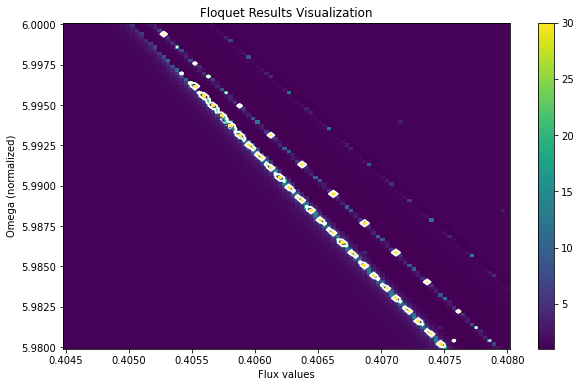

In [272]:
# Plotting
X, Y = np.meshgrid(flux_values, omega_values / (2 * np.pi))  # Correcting omega scale for plotting
plt.figure(figsize=(10, 6))
cp = plt.pcolormesh(X, Y, dephasing,  cmap='viridis',vmin=1, vmax=30)
plt.colorbar(cp)
plt.title('Floquet Results Visualization')
plt.xlabel('Flux values')
plt.ylabel('Omega (normalized)')
contours = plt.contour(X, Y, dephasing, levels=[15], colors='white', linewidths=2)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

plt.show()

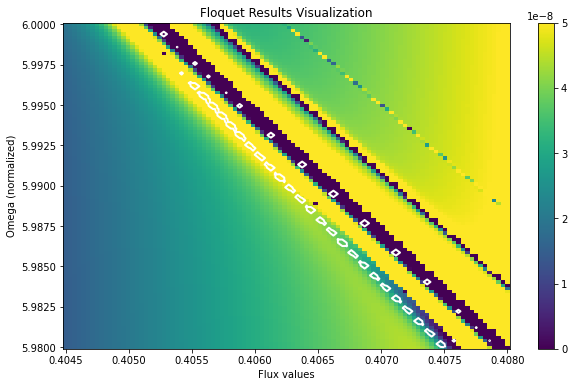

In [276]:
# Plotting
X, Y = np.meshgrid(flux_values, omega_values / (2 * np.pi))  # Correcting omega scale for plotting
plt.figure(figsize=(10, 6))
cp = plt.pcolormesh(X, Y, selfkerr, cmap='viridis',vmin=0, vmax=5e-8)
plt.colorbar(cp)
contours = plt.contour(X, Y, dephasing, levels=[15], colors='white', linewidths=2)
plt.title('Floquet Results Visualization')
plt.xlabel('Flux values')
plt.ylabel('Omega (normalized)')
plt.show()

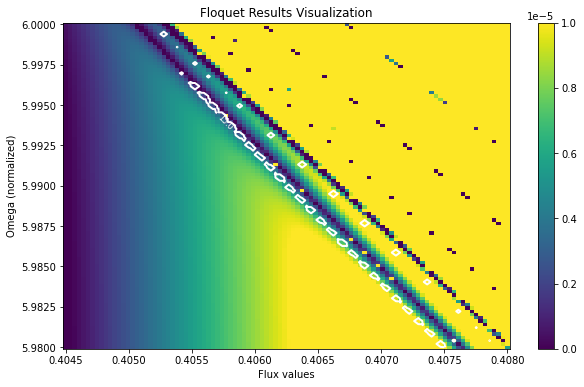

In [278]:
# Plotting
X, Y = np.meshgrid(flux_values, omega_values / (2 * np.pi))  # Correcting omega scale for plotting
plt.figure(figsize=(10, 6))
cp = plt.pcolormesh(X, Y, disp, cmap='viridis', vmin=0, vmax=1e-5)
plt.colorbar(cp)
plt.title('Floquet Results Visualization')
plt.xlabel('Flux values')
plt.ylabel('Omega (normalized)')
contours = plt.contour(X, Y, dephasing, levels=[15], colors='white', linewidths=2)
plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')
plt.show()